In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


# === Load Data ===
df = pd.read_csv("sales_data_pdp.csv")

df.head()


,datetime,hour,day_of_week,day,month,is_weekend,temperature,humidity,weather,promo,holiday,store_id,customers,sales
0,2025-06-01 00:00:00,0,6,1,6,1,25.993428,82.890590,sunny,0,0,D,44.960910,344.575071
1,2025-06-01 01:00:00,1,6,1,6,1,26.028733,79.798921,sunny,1,0,B,70.783329,470.694206
2,2025-06-01 02:00:00,2,6,1,6,1,28.883568,78.834660,sunny,0,0,A,70.245109,491.689325
3,2025-06-01 03:00:00,3,6,1,6,1,31.872894,71.580495,sunny,0,0,A,73.636501,500.329790
4,2025-06-01 04:00:00,4,6,1,6,1,29.531693,68.544177,rainy,0,0,A,57.397301,450.371053


In [2]:
# === Feature Engineering ===
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["promo_weekend"] = df["promo"] * df["is_weekend"]
df["temp_bin"] = pd.cut(df["temperature"], bins=4, labels=False)

df.head()

,datetime,hour,day_of_week,day,month,is_weekend,temperature,humidity,weather,promo,holiday,store_id,customers,sales,hour_sin,hour_cos,promo_weekend,temp_bin
0,2025-06-01 00:00:00,0,6,1,6,1,25.993428,82.890590,sunny,0,0,D,44.960910,344.575071,0.000000,1.000000,0,1
1,2025-06-01 01:00:00,1,6,1,6,1,26.028733,79.798921,sunny,1,0,B,70.783329,470.694206,0.258819,0.965926,1,1
2,2025-06-01 02:00:00,2,6,1,6,1,28.883568,78.834660,sunny,0,0,A,70.245109,491.689325,0.500000,0.866025,0,1
3,2025-06-01 03:00:00,3,6,1,6,1,31.872894,71.580495,sunny,0,0,A,73.636501,500.329790,0.707107,0.707107,0,2
4,2025-06-01 04:00:00,4,6,1,6,1,29.531693,68.544177,rainy,0,0,A,57.397301,450.371053,0.866025,0.500000,0,1


In [3]:
# === Define features and target ===
X = df.drop(columns=["sales", "datetime", "customers", "sales_per_customer"], errors="ignore")
y = df["sales"]

print(X.head())
print(f"y.head():\n{y.head()}")

   hour  day_of_week  day  month  is_weekend  temperature   humidity weather  \
0     0            6    1      6           1    25.993428  82.890590   sunny   
1     1            6    1      6           1    26.028733  79.798921   sunny   
2     2            6    1      6           1    28.883568  78.834660   sunny   
3     3            6    1      6           1    31.872894  71.580495   sunny   
4     4            6    1      6           1    29.531693  68.544177   rainy   

   promo  holiday store_id  hour_sin  hour_cos  promo_weekend  temp_bin  
0      0        0        D  0.000000  1.000000              0         1  
1      1        0        B  0.258819  0.965926              1         1  
2      0        0        A  0.500000  0.866025              0         1  
3      0        0        A  0.707107  0.707107              0         2  
4      0        0        A  0.866025  0.500000              0         1  
y.head():
0    344.575071
1    470.694206
2    491.689325
3    500.329790
4

In [4]:
# Identify categorical and numeric columns
categorical_cols = ["weather", "store_id"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print(f"Categorical columns:\n{categorical_cols}")
print(f"Numeric columns:\n{numeric_cols}")


Categorical columns:
['weather', 'store_id']
Numeric columns:
['hour', 'day_of_week', 'day', 'month', 'is_weekend', 'temperature', 'humidity', 'promo', 'holiday', 'hour_sin', 'hour_cos', 'promo_weekend', 'temp_bin']


In [5]:
# === Preprocessing ===
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

preprocessor

,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


In [6]:
# === Model ===
model = RandomForestRegressor(
    n_estimators=200, random_state=42, max_depth=10, n_jobs=-1
)

model

,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# === Pipeline ===
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
from sklearn.model_selection import train_test_split

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

(2342, 15)

In [12]:
# === Train Model ===
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
# === Predict ===
y_pred = pipeline.predict(X_test)

In [15]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Evaluate ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

MAE: 38.952
RMSE: 49.071
R²: 0.862


In [22]:
# === Feature Importance ===
encoded_features = list(
    pipeline.named_steps["preprocessor"]
    .transformers_[0][1]
    .get_feature_names_out(categorical_cols)
)
all_features = encoded_features + numeric_cols

importances = pipeline.named_steps["model"].feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df.head(10)

,feature,importance
7,hour,0.606119
14,promo,0.075616
17,hour_cos,0.069932
8,day_of_week,0.065483
11,is_weekend,0.059886
12,temperature,0.030210
13,humidity,0.018954
16,hour_sin,0.017037
18,promo_weekend,0.016313
9,day,0.014682


In [19]:
all_features

['weather_cloudy',
 'weather_rainy',
 'weather_sunny',
 'store_id_A',
 'store_id_B',
 'store_id_C',
 'store_id_D',
 'hour',
 'day_of_week',
 'day',
 'month',
 'is_weekend',
 'temperature',
 'humidity',
 'promo',
 'holiday',
 'hour_sin',
 'hour_cos',
 'promo_weekend',
 'temp_bin']

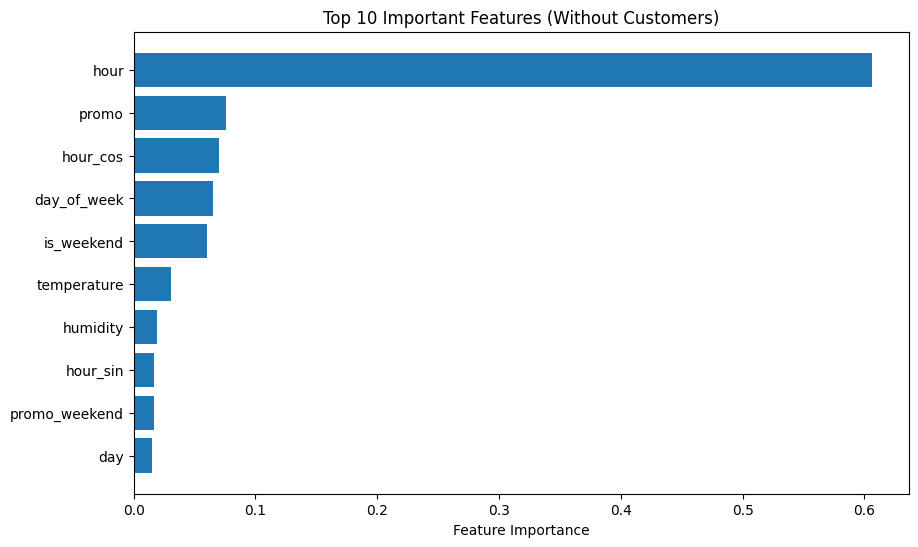

In [23]:
import matplotlib.pyplot as plt


# === Plot Feature Importance ===
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"][:10][::-1], 
         feature_importance_df["importance"][:10][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Without Customers)")
plt.show()

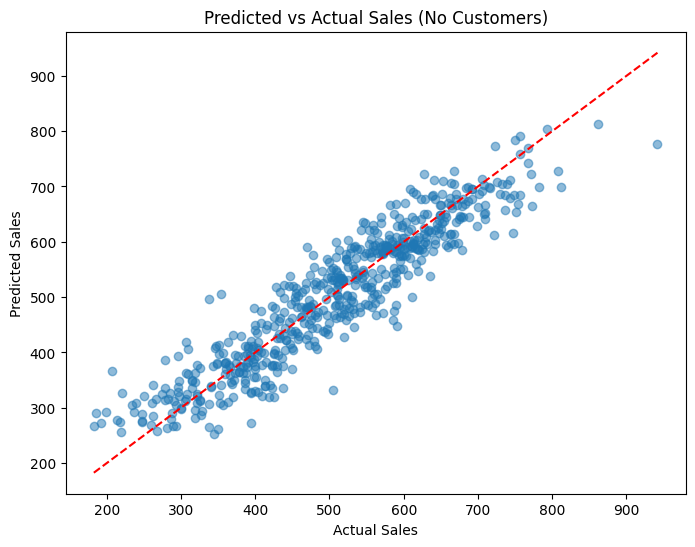

In [24]:
# === Plot Predicted vs Actual ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales (No Customers)")
plt.show()